<a href="https://colab.research.google.com/github/Rishicode09/Risk-Prediction-Models-in-Python-Credit-Volatility-/blob/main/risk_prediction_models_in_python_credit_volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ROC AUC: 0.6676960741894543
PR AUC: 0.2443941145425029
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1284
           1       0.17      0.00      0.01       216

    accuracy                           0.85      1500
   macro avg       0.51      0.50      0.46      1500
weighted avg       0.76      0.85      0.79      1500

Confusion Matrix:
 [[1279    5]
 [ 215    1]]


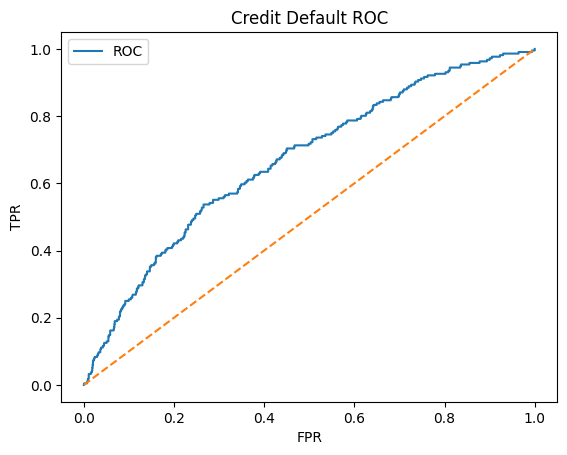

              feature  importance
6        credit_score    0.000400
4  past_delinquencies    0.000267
9             purpose    0.000133
3      num_open_loans    0.000000
1                 age   -0.000400
2         credit_util   -0.000400
8      home_ownership   -0.000800
7   employment_status   -0.000800
5      debt_to_income   -0.001733
0              income   -0.001867


/tmp/ipython-input-479035979.py:153: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target = returns.rolling(horizon).std().shift(-horizon).fillna(method="ffill").rename("future_vol")


CV RMSE: -0.003485592658148478 ± 0.0004060182064561815
Holdout RMSE: 0.004498484931789783
MAE: 0.0038006840068360065
R^2: -0.1993309666182812
Rolling Forecast RMSE: 0.002876967930008753


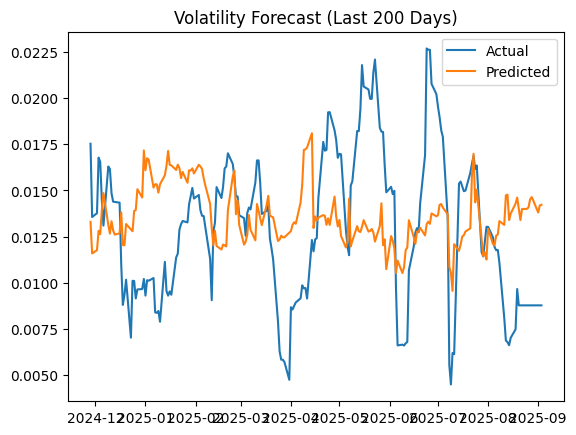

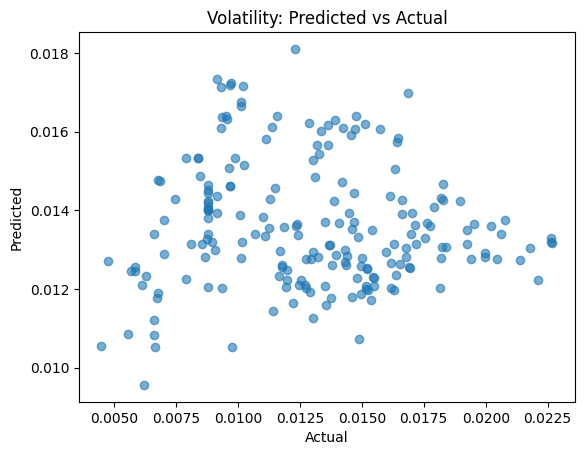

Models saved: credit_default_model.joblib, volatility_model.joblib


In [ ]:
# ============================================================
# 📘 Risk Prediction Models in Python (Credit + Volatility)
# Beginner-friendly, Colab-ready with full explanations
# ============================================================

# --- Install dependencies (only needed in Colab, skip if local)
!pip install scikit-learn joblib matplotlib pandas numpy
!pip install -U scikit-learn
# --- Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import joblib

# ============================================================
# 🔹 PART 1: CREDIT DEFAULT PREDICTION
# ============================================================

# --- Step 1: Generate synthetic credit dataset
rng = np.random.RandomState(7)  # random number generator
n_samples = 6000  # number of "customers"
income = rng.lognormal(mean=10.2, sigma=0.5, size=n_samples)
age = rng.normal(loc=38, scale=10, size=n_samples).clip(18, 75)
credit_util = rng.beta(a=2, b=5, size=n_samples) * 1.2
num_open_loans = rng.poisson(lam=2.5, size=n_samples).clip(0, 12)
past_delinquencies = rng.poisson(lam=0.4, size=n_samples).clip(0, 10)
debt_to_income = (rng.beta(2, 3, n_samples) * 1.5).clip(0, 2.0)
credit_score = (rng.normal(650, 70, n_samples)).clip(300, 850)

employment_status = rng.choice(["full_time", "part_time", "unemployed", "self_employed"], size=n_samples, p=[0.6, 0.2, 0.1, 0.1])
home_ownership = rng.choice(["rent", "own", "mortgage"], size=n_samples, p=[0.45, 0.25, 0.30])
purpose = rng.choice(["debt_consolidation", "car", "home_improvement", "small_business", "education", "medical"], size=n_samples)

# --- Step 2: Build probability of default (logistic model)
logit = (
    -3.8
    + 0.00008 * (700 - credit_score)
    + 1.2 * credit_util
    + 0.9 * debt_to_income
    + 0.5 * (past_delinquencies > 0)
    + 0.25 * (num_open_loans > 6)
    - 0.00003 * (income - 50000)
    + 0.02 * (35 - age)
    + 0.5 * (employment_status == "unemployed")
    + 0.2 * (home_ownership == "rent")
    + 0.25 * (purpose == "small_business")
)
p_default = 1 / (1 + np.exp(-logit))
y_default = rng.binomial(1, p_default)

# --- Step 3: Put everything into a DataFrame
credit_df = pd.DataFrame({
    "income": income, "age": age, "credit_util": credit_util,
    "num_open_loans": num_open_loans, "past_delinquencies": past_delinquencies,
    "debt_to_income": debt_to_income, "credit_score": credit_score,
    "employment_status": employment_status, "home_ownership": home_ownership,
    "purpose": purpose, "default": y_default
})

# --- Step 4: Split features & labels
X = credit_df.drop(columns=["default"])
y = credit_df["default"]

# --- Step 5: Preprocessing
num_cols = ["income", "age", "credit_util", "num_open_loans", "past_delinquencies", "debt_to_income", "credit_score"]
cat_cols = ["employment_status", "home_ownership", "purpose"]

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
])

# --- Step 6: Build pipeline with Gradient Boosting Classifier
clf = Pipeline([("preprocess", preprocess), ("model", GradientBoostingClassifier(random_state=42))])

# --- Step 6b: Hyperparameter tuning (Employer-ready)
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [3, 5],
    "model__learning_rate": [0.05, 0.1]
}
grid_clf = GridSearchCV(clf, param_grid, cv=3, scoring="roc_auc")
# --- Step 7: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
grid_clf.fit(X_train, y_train)
clf_best = grid_clf.best_estimator_

# --- Step 8: Evaluate
y_proba = clf_best.predict_proba(X_val)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_val, y_proba))
print("PR AUC:", average_precision_score(y_val, y_proba))
print(classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

# --- Step 9: Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1], [0,1], "--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Credit Default ROC"); plt.legend()
plt.show()

# --- Step 10: Feature importance
perm = permutation_importance(clf_best, X_val, y_val, n_repeats=5, random_state=42)
imp_df = pd.DataFrame({"feature": list(X.columns), "importance": perm.importances_mean})
print(imp_df.sort_values("importance", ascending=False))

# ============================================================
# 🔹 PART 2: STOCK VOLATILITY FORECAST
# ============================================================

# --- Step 1: Simulate stock prices using Geometric Brownian Motion
rng = np.random.RandomState(42)
n_days = 2000
dt = 1/252
mu, sigma = 0.08, 0.22
prices = [100]
for _ in range(1, n_days):
    z = rng.normal()
    prices.append(prices[-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z))

dates = pd.bdate_range(end=pd.Timestamp.today(), periods=n_days)
prices = pd.Series(prices, index=dates, name="price")
returns = prices.pct_change().fillna(0.0)

# --- Step 2: Create technical features
def rolling_features(ser, windows):
    feats = {}
    for w in windows:
        feats[f"ret_ema_{w}"] = ser.ewm(span=w, adjust=False).mean()
        feats[f"ret_roll_mean_{w}"] = ser.rolling(w).mean()
        feats[f"ret_roll_std_{w}"] = ser.rolling(w).std().fillna(0.0)
    return pd.DataFrame(feats, index=ser.index)

feat_df = rolling_features(returns, [5, 10, 20, 60])
for l in [1,2,3,5,10]:
    feat_df[f"ret_lag_{l}"] = returns.shift(l)

# --- Step 3: Target = future volatility
horizon = 10
target = returns.rolling(horizon).std().shift(-horizon).fillna(method="ffill").rename("future_vol")
data = pd.concat([feat_df, target], axis=1).dropna()

X_vol = data.drop(columns=["future_vol"])
y_vol = data["future_vol"]

# --- Step 4: Train Gradient Boosting Regressor
reg = GradientBoostingRegressor(random_state=42)
ts = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(reg, X_vol, y_vol, cv=ts, scoring="neg_root_mean_squared_error")
print("CV RMSE:", scores.mean(), "±", scores.std())

reg.fit(X_vol.iloc[:-200], y_vol.iloc[:-200])
y_pred = reg.predict(X_vol.iloc[-200:])
y_true = y_vol.iloc[-200:]

# --- Step 4b: Backtesting / rolling forecast evaluation (Employer-ready)
rolling_window = 200
preds, trues = [], []
for start in range(len(X_vol) - rolling_window):
    end = start + rolling_window
    reg.fit(X_vol.iloc[start:end], y_vol.iloc[start:end])
    pred = reg.predict(X_vol.iloc[end:end+1])
    preds.append(pred[0])
    trues.append(y_vol.iloc[end])

# --- Step 5: Evaluate
print("Holdout RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R^2:", r2_score(y_true, y_pred))

print("Rolling Forecast RMSE:", np.sqrt(mean_squared_error(trues, preds)))

# --- Step 6: Plots
plt.plot(y_true.index, y_true.values, label="Actual")
plt.plot(y_true.index, y_pred, label="Predicted")
plt.legend(); plt.title("Volatility Forecast (Last 200 Days)")
plt.show()

plt.scatter(y_true, y_pred, alpha=0.6)
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("Volatility: Predicted vs Actual")
plt.show()

# ============================================================
# 🔹 PART 3: SAVE MODELS
# ============================================================
joblib.dump(clf_best, "credit_default_model.joblib")
joblib.dump(reg, "volatility_model.joblib")
print("Models saved: credit_default_model.joblib, volatility_model.joblib")

